<center>
<h3>Exploring Iloilo Radar Data</h3>
</center>
<header style=\"margin-top: -5px;\">
<h5>
<center>
Irene Crisologo
<br>
<small>
April 29, 2016
</small>
</center>
</h5>
</header>


The Iloilo (ILO) radar data started to be archived in the ASTI repository on 22 April 2016. 

The current read_EDGE_netcdf function in wradlib does not yet support the netCDF file from Iloilo radar, so here the file structure is explored. The general attributes of the volume scan of ILO is investigated here as well.

In [11]:
%pylab inline
import numpy as np
import pylab as pl
import netCDF4 as nc
import datetime as dt
import wradlib as wrl
import os

from matplotlib.collections import PatchCollection
import matplotlib.patches as patches

Populating the interactive namespace from numpy and matplotlib


First we explore a single file. For this we take the first sweep of the reflectivity data.

In [12]:
fpath = r"Q:\radar\philippines\repo.pscigrid.gov.ph\radar\netcdf\iloilo\2016\04\22"
fname = "1170ILO-20160422-072032-PPIVol-001-ZH.nc"

Read the netCDF file.

In [13]:
dset = nc.Dataset(os.path.join(fpath,fname))

List down the variables available with the file.

In [14]:
dset.variables.keys()

[u'volume_number',
 u'latitude',
 u'longitude',
 u'altitude',
 u'time_coverage_start',
 u'time_coverage_end',
 u'time',
 u'azimuth',
 u'elevation',
 u'radar_antenna_gain_h',
 u'radar_antenna_gain_v',
 u'radar_beam_width_h',
 u'radar_beam_width_v',
 u'radar_receiver_bandwidth',
 u'frequency',
 u'radar_measured_transmit_power_h',
 u'radar_measured_transmit_power_v',
 u'pulse_width',
 u'prt',
 u'prt_ratio',
 u'nyquist_velocity',
 u'n_samples',
 u'prt_mode',
 u'polarization_mode',
 u'range',
 u'sweep_number',
 u'sweep_mode',
 u'fixed_angle',
 u'sweep_start_ray_index',
 u'sweep_end_ray_index',
 u'DBZH']

Let us extract the reflectivity data, which is stored under the 'DBZH' entry.

In [15]:
data = dset.variables[u'DBZH'][:]

Get the azimuth and range data as well.

In [16]:
az = dset.variables['azimuth']
r = dset.variables['range'][:]
maxrange = np.max(dset.variables['range'][:])

Rotate the data such that the first entry corresponds to the 0 azimuth angle (North)

In [17]:
# These are the indices of the minimum and maximum azimuth angle
ix_minaz = np.argmin(az)
ix_maxaz = np.argmax(az)
# rotate accordingly
az = np.roll(az, -ix_minaz)
data = np.roll(data, -ix_minaz, axis=0)

Replace the missing values with NaN

In [18]:
# fill in missing values with nan
data = np.where(data == float(dset.variables[u'DBZH']._FillValue), np.nan, data)
data = np.where(data == float(dset.variables[u'DBZH']._FillValue), np.nan, data)
# i still have to figure out why it doesn't work when I execute the line only once

Collect all the attributes and add the most commonly used ones, that follow the format of the other radar data.

In [19]:
# collect attributes
attrs = {}
for attrname in dset.variables.keys():
    if attrname != u'DBZH':
        attrs[attrname] = dset.variables[attrname][:]
# set additional metadata attributes
attrs['az'] = az
attrs['r'] = r
attrs['sitecoords'] = (float((attrs['longitude'])), float((attrs['latitude'])),
                       float((attrs['altitude'])))
attrs['time'] = dt.datetime.strptime(''.join(dset.variables[u'time_coverage_start'][:].tolist()), '%Y-%m-%dT%H:%M:%SZ')
attrs['max_range'] = maxrange

#### What we know so far about ILOILO radar:
###### Sweep 1:
    * Range resolution : 250m
    * Maximum range value : 480km
    * Azimuth resolution : 0.46 degrees
    * Coordinates : 122.58N, 10.77E, 30m altitude

Sample plot!

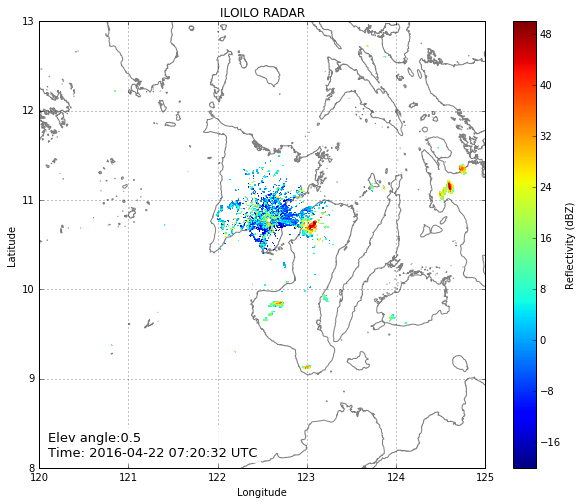

In [20]:
proj_rad = wrl.georef.get_default_projection()

# Read shapefile for overlay
dataset, inLayer = wrl.io.open_shape("P:/progress/ECHSE_projects/general_shpfiles/country_borders/PHL_Dissolve.shp")
borders, keys = wrl.georef.get_shape_coordinates(inLayer, key='Id')

fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111, aspect="equal")
trg_patches = [patches.Polygon(item, True) for item in borders ]
p = PatchCollection(trg_patches, facecolor="None", edgecolor="grey", linewidth=1)
ax.add_collection(p)
ax,pm = wrl.vis.plot_ppi(np.ma.masked_invalid(data),r=attrs['r'], az=attrs['az'],
                 site=(attrs['sitecoords'][0],attrs['sitecoords'][1]), ax=ax, proj=proj_rad,
                 vmax=50, vmin=-20)
txt = "Elev angle:%s\nTime: %s UTC" % (float(attrs['fixed_angle']), attrs['time'].isoformat(" "))
pl.text(120+0.1, 8+0.1, txt, 
         color="black", horizontalalignment='left', verticalalignment="bottom", 
         fontsize=13, bbox=dict(facecolor='white', edgecolor="None", alpha=0.8))
pl.xlim(120, 125)
pl.ylim(8, 13)
pl.xlabel("Longitude")
pl.ylabel("Latitude")
pl.grid()
cb = pl.colorbar(pm, shrink=0.8)
cb.set_label("Reflectivity (dBZ)")
pl.title('ILOILO RADAR')